<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 10%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.1
loss_function = 'DampedRCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedRCELoss_aircrafts_asym_0.1_0.25_baseline
Model Features: DampedRCELoss_aircrafts_asym_0.1_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedRCELoss_aircrafts_asym_0.1_0.25
Csv save: DampedRCELoss_aircrafts_asym_0.1_0.25
Saving features from Scheme delta = 0.25: DampedRCELoss_aircrafts_asym_0.1_0.5
Saving csv for damp_2: DampedRCELoss_aircrafts_asym_0.1_0.5


# Declaration of Efficient Net family with Resolution, and  Batch size

In [3]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [4]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

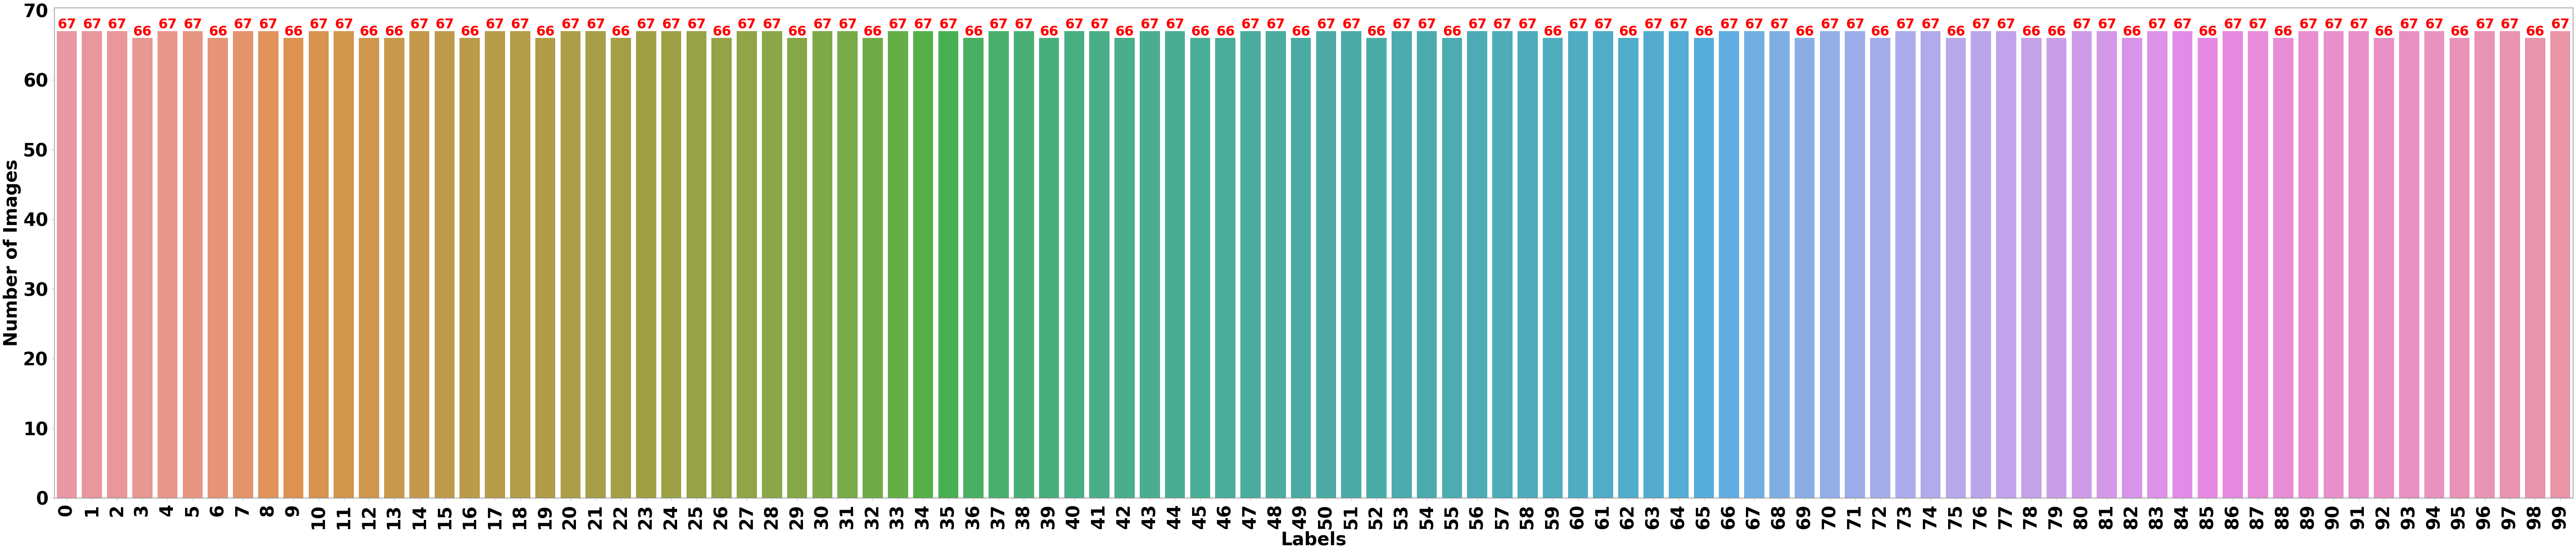

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [7]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


In [9]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [10]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

,Filepath,Label
0,testing/0/0789828.jpg,0
1,testing/0/1453508.jpg,0
2,testing/0/0895165.jpg,0
3,testing/0/0536515.jpg,0
4,testing/0/0747566.jpg,0
...,...,...
3328,testing/99/0973160.jpg,99
3329,testing/99/0197892.jpg,99
3330,testing/99/1176955.jpg,99
3331,testing/99/1298910.jpg,99


In [11]:
my_list = sorted_df.Label.unique()

In [12]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [13]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

,Filepath,Label,Label_numeric
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [14]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

,Filepath,Label_numeric,Label
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [15]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [16]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

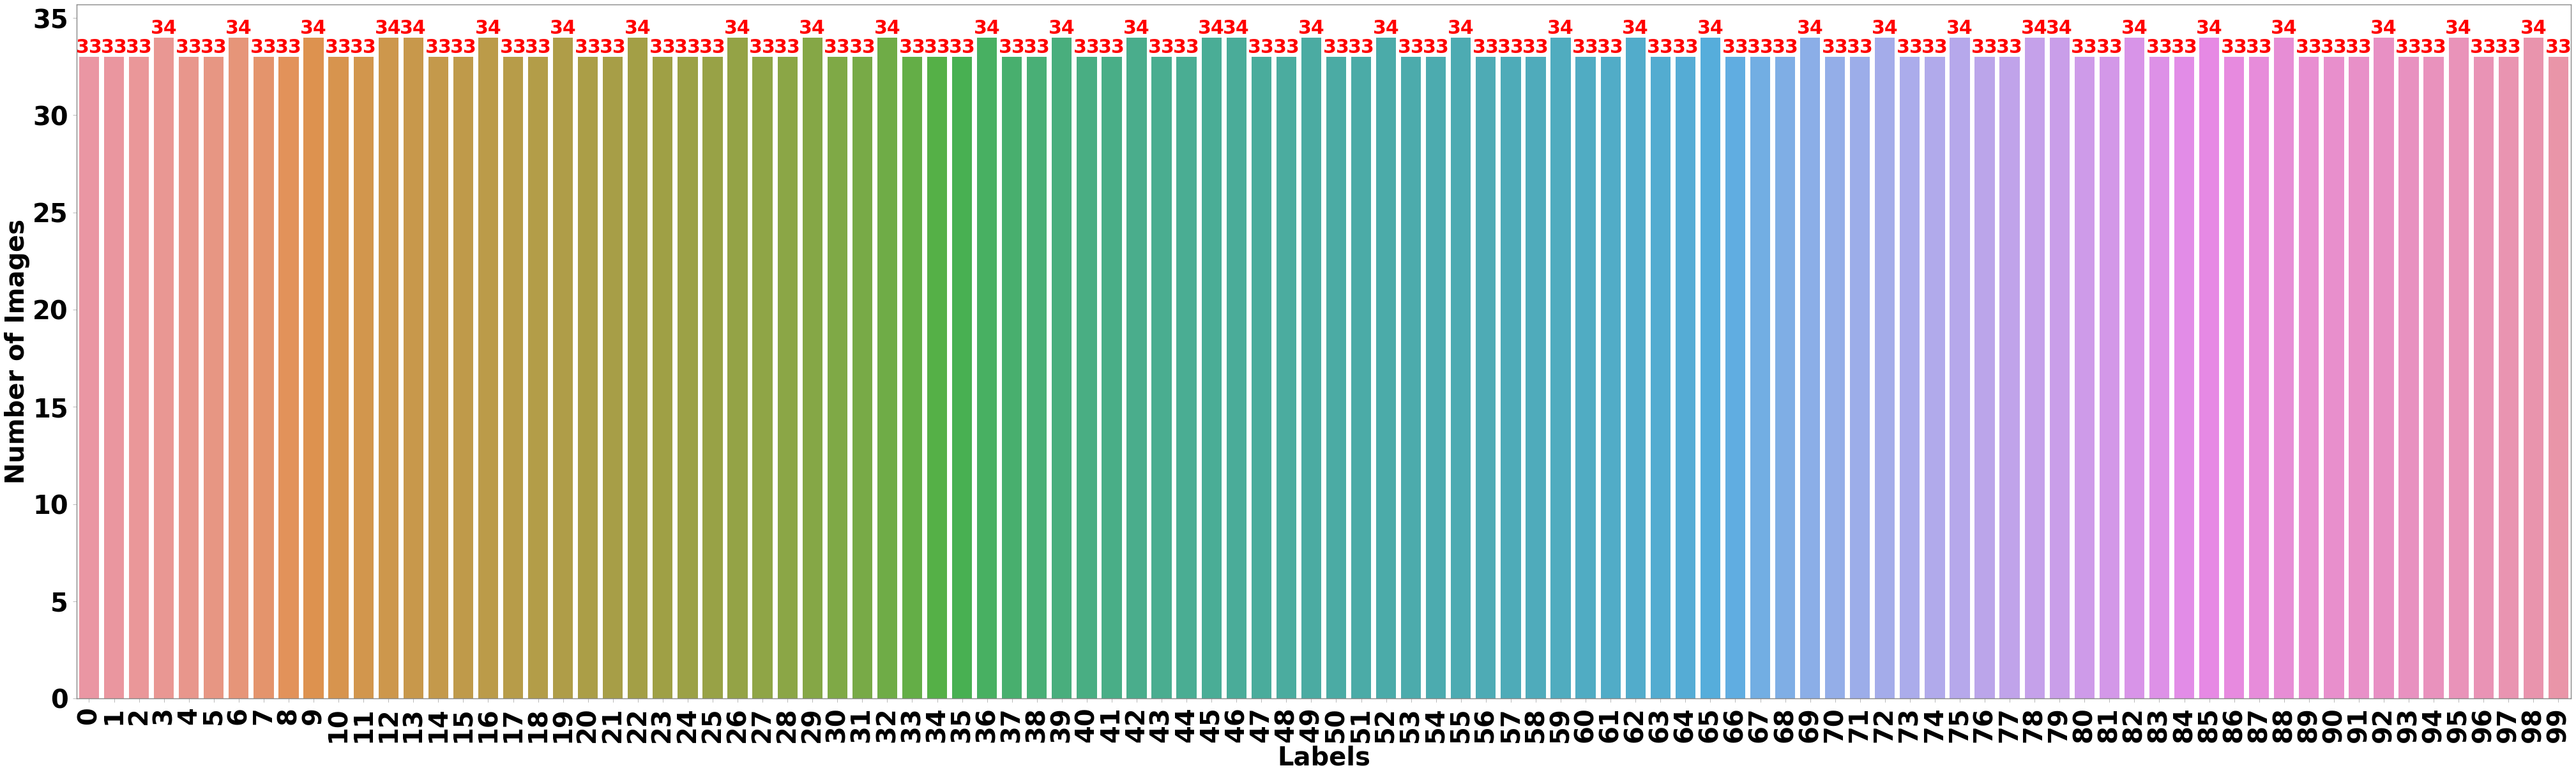

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [21]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [22]:

# default augmentation
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


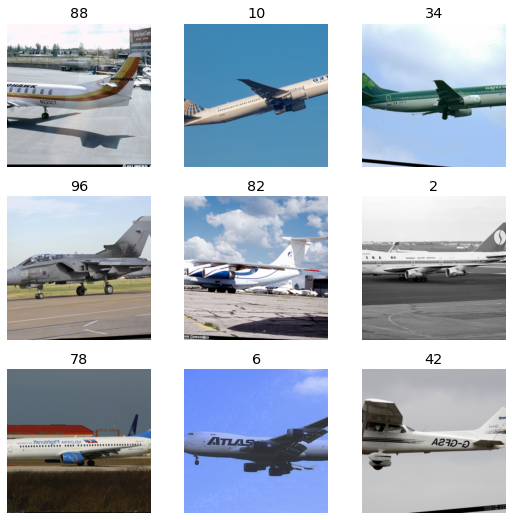

In [23]:
data0.show_batch()

In [24]:
import damped_losses as losses
loss_func = losses.DampedRCELossFlat(num_classes=num_classes,scale=20.0, delta = 0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [25]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= rce_aircrafts_asym_0.1_baseline


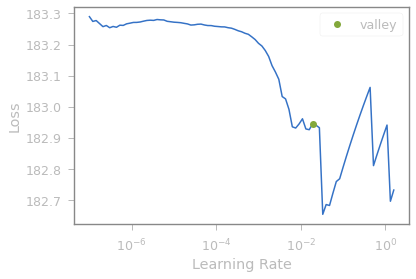

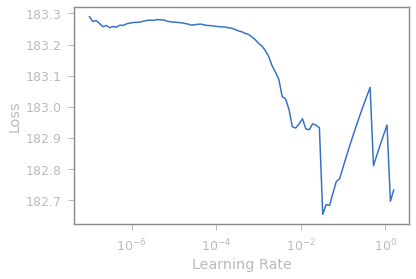

In [26]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,173.376709,172.779526,0.070518,01:50
1,170.596512,178.450333,0.032258,01:49
2,179.161179,180.087418,0.021755,01:50
3,178.882690,179.787323,0.024756,01:49
4,181.561798,182.287766,0.010503,01:50
5,181.667480,181.404175,0.015754,01:50
6,180.668777,181.426407,0.014254,01:50
7,181.091858,181.387054,0.015004,01:50
8,180.869583,180.623520,0.019505,01:50
9,181.087021,180.717331,0.018005,01:50


Better model found at epoch 0 with accuracy value: 0.0705176293849945.


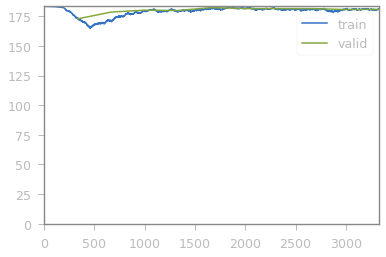

In [27]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,158.866608,158.157333,0.170293,01:50
1,146.526825,143.661194,0.243811,01:50
2,129.934998,127.792328,0.333833,01:50
3,113.075722,112.855545,0.405851,01:50
4,102.108109,104.279083,0.444861,01:50
5,97.369377,112.764954,0.399100,01:50
6,96.801514,107.191849,0.428357,01:50
7,100.971443,107.819862,0.421605,01:49
8,100.196495,108.063110,0.421605,01:50
9,95.126465,112.380684,0.396099,01:50


Better model found at epoch 0 with accuracy value: 0.17029257118701935.


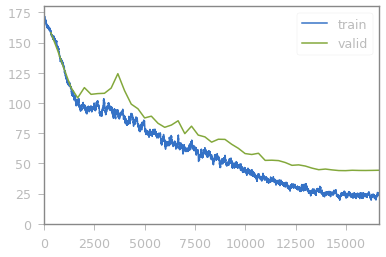

Better model found at epoch 1 with accuracy value: 0.24381095170974731.
Better model found at epoch 2 with accuracy value: 0.3338334560394287.
Better model found at epoch 3 with accuracy value: 0.40585145354270935.
Better model found at epoch 4 with accuracy value: 0.44486120343208313.
Better model found at epoch 12 with accuracy value: 0.4688672125339508.
Better model found at epoch 13 with accuracy value: 0.49137285351753235.
Better model found at epoch 14 with accuracy value: 0.5333833694458008.
Better model found at epoch 16 with accuracy value: 0.5581395626068115.
Better model found at epoch 17 with accuracy value: 0.5746436715126038.
Better model found at epoch 20 with accuracy value: 0.6076518893241882.
Better model found at epoch 23 with accuracy value: 0.6151537895202637.
Better model found at epoch 24 with accuracy value: 0.634658694267273.
Better model found at epoch 27 with accuracy value: 0.6436609029769897.
Better model found at epoch 28 with accuracy value: 0.66241562366

In [29]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [30]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.8326)


In [31]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.8488)


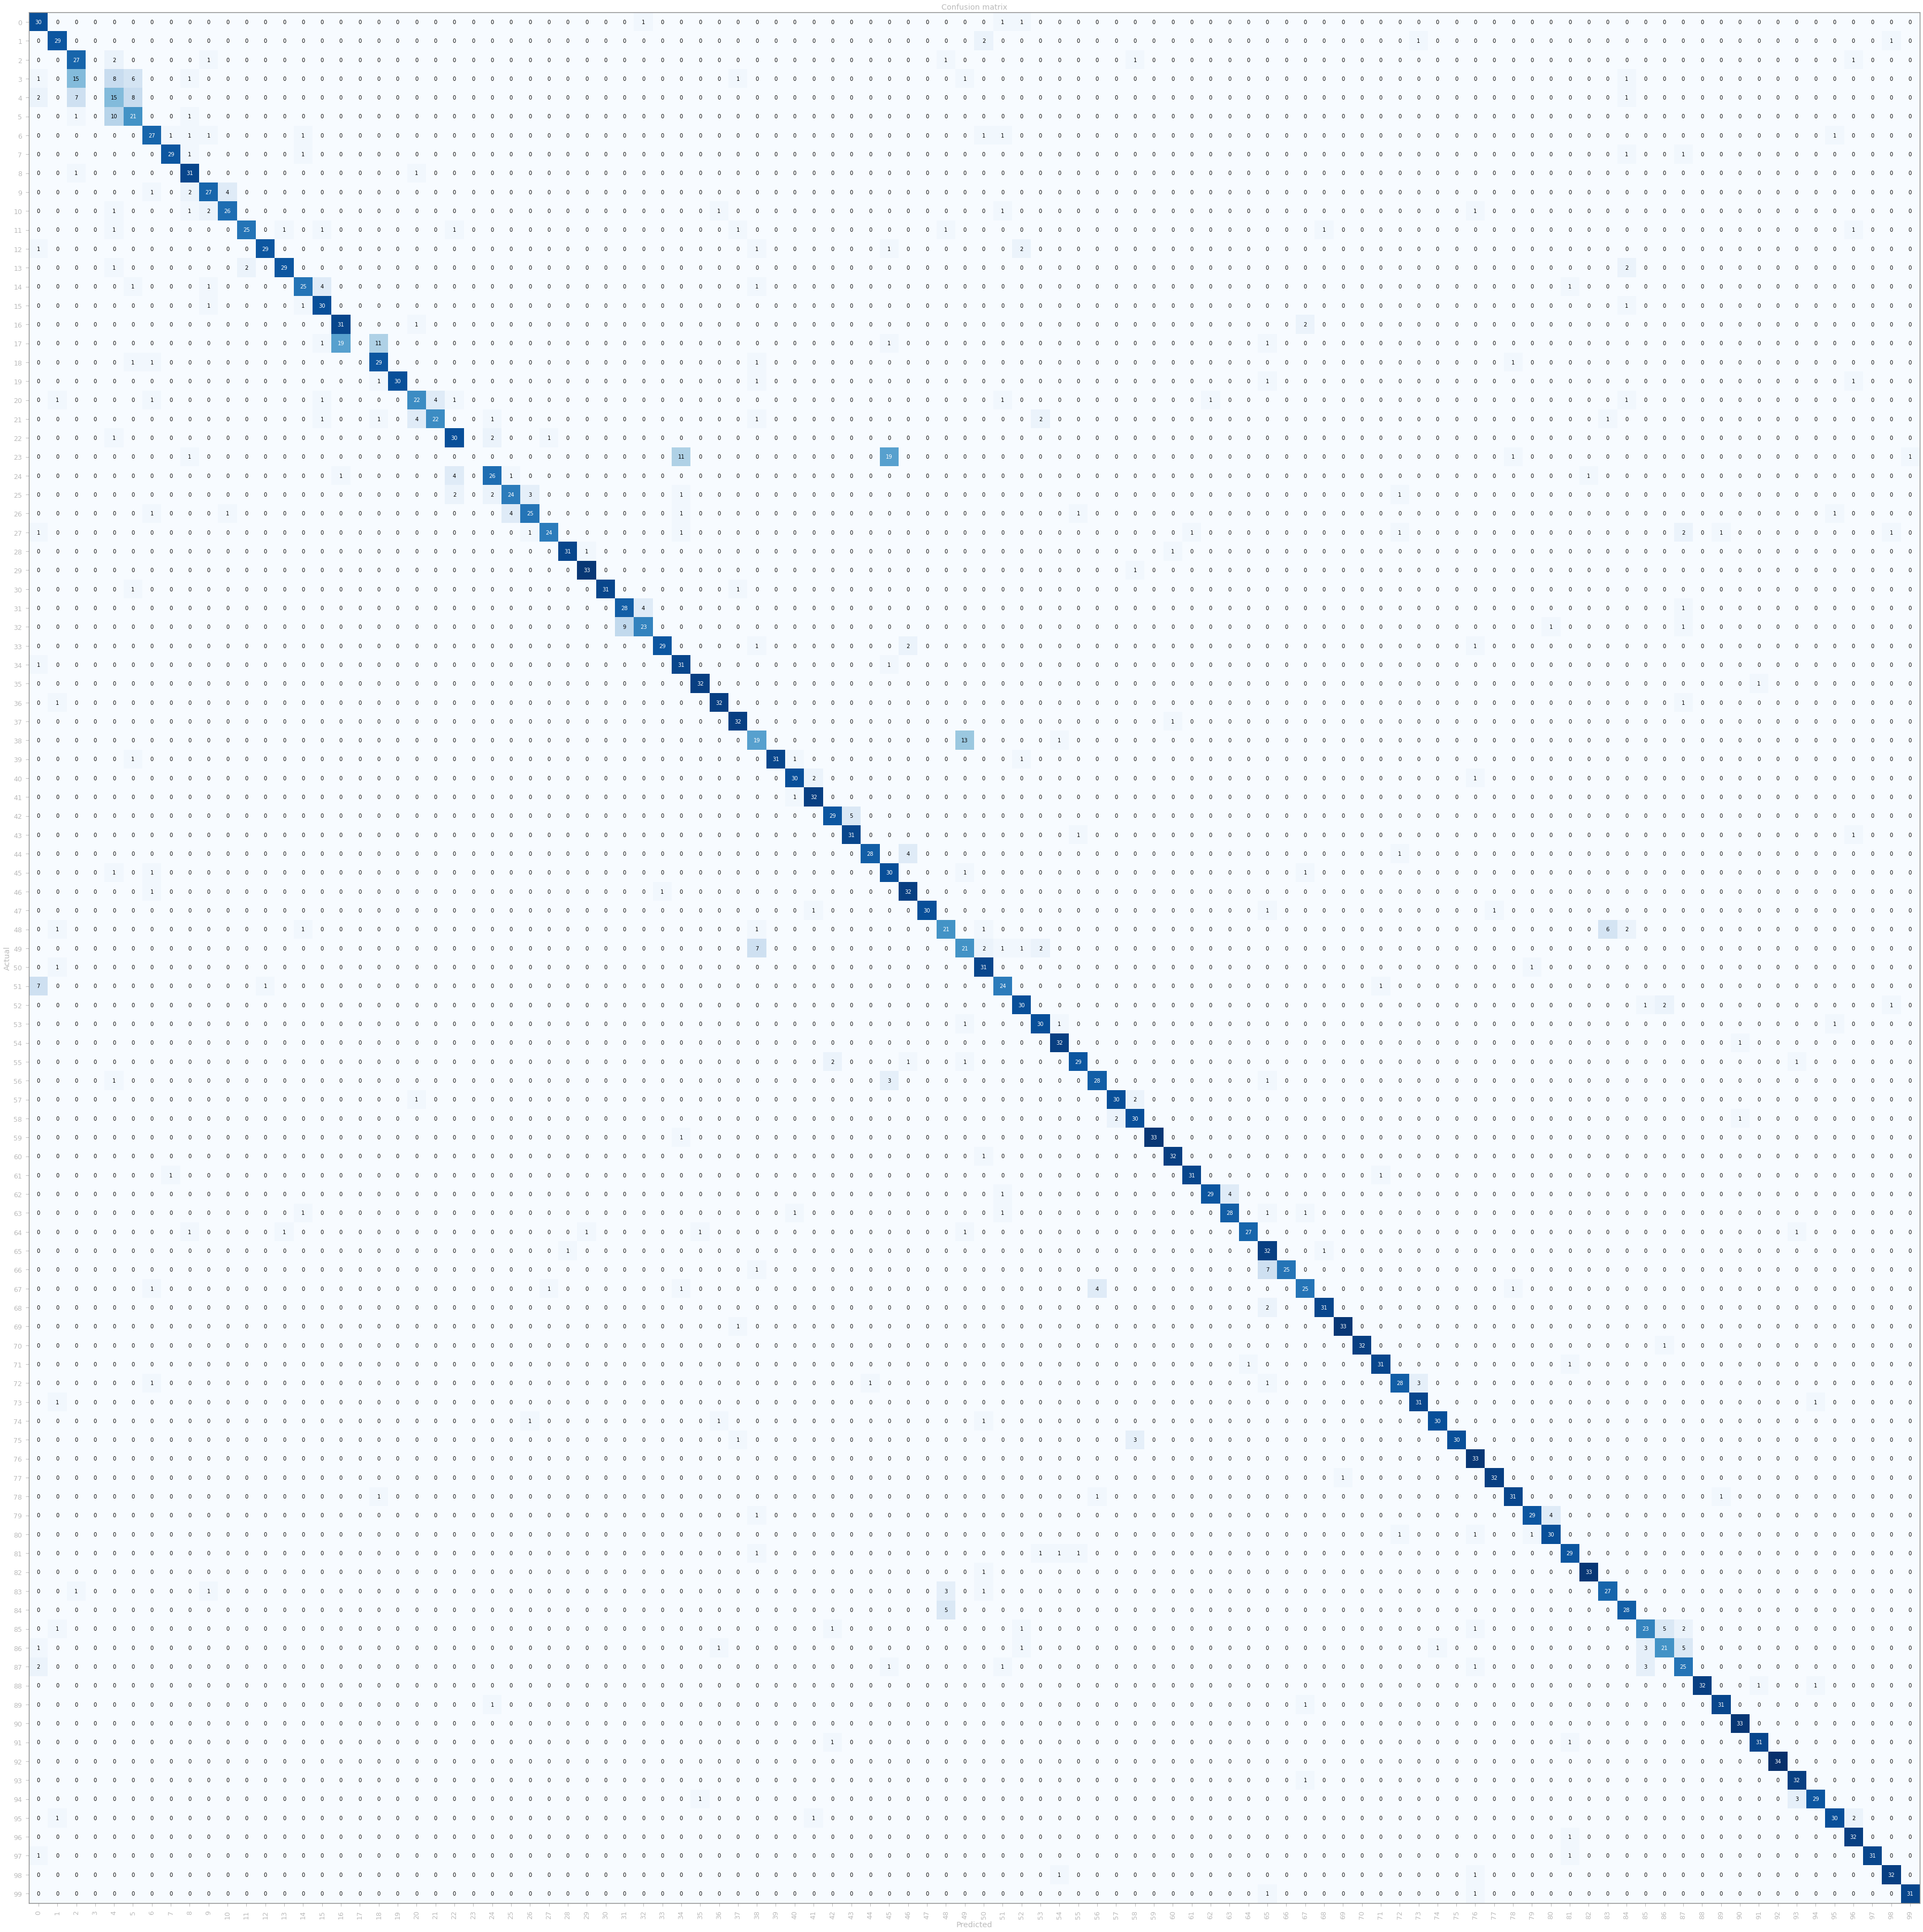

In [32]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [33]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [34]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/rce_aircrafts_asym_0.1_baseline.pth'

In [35]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering


def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
        #print(f'Frequency of class {cl}: {class_freq[cl]} ')
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
#     deltap = 0.0
#     if max_prob > min_prob:
#         deltap = (max_prob - min_prob)/(max_freq-min_freq)
            
    
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
#         print("+++++++++ L", l)
#         prob = min_prob + deltap * (class_freq[l]**2)
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
#         print("rrr",r, "prob+++", prob)
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
#     print(class_freq)# returns number of images per class
    return drop_idx

def data_definition(data,img_size,tfms,model,best_pth,k_samples=100, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

#     
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
#     entire_training_set_learner0 = (learner_type(entire_training_set_csv0, model, metrics=[accuracy]).to_fp16())
#     entire_training_set_learner0.load(best_pth)
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    

#     interp.plot_top_losses(100, figsize = (11,15))
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    #top_losses = pd.DataFrame(data.iloc[drop_idx])
    #top_losses = top_losses.to_csv('top_losses'+str(n+1)+'.csv', index = False)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered


# Dump 0.25 with Cleaning Scheme

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 92 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6575


epoch,train_loss,valid_loss,accuracy,time
0,31.264706,27.882084,0.850951,01:49


Better model found at epoch 0 with accuracy value: 0.8509505987167358.


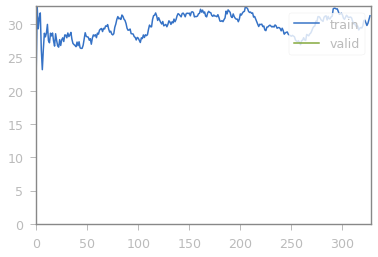

************Round:  0
TTA Accuracy:0.8442844152450562
cycle 0 Error Rate is [{0: (1.3799310034498302, 15.571558475494385)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 78 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6497


epoch,train_loss,valid_loss,accuracy,time
0,29.146908,25.163380,0.863741,01:46


Better model found at epoch 0 with accuracy value: 0.8637413382530212.


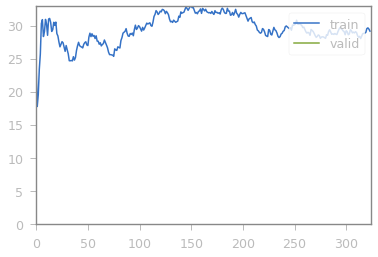

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 79 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6418


epoch,train_loss,valid_loss,accuracy,time
0,31.403425,28.251879,0.846454,01:45


Better model found at epoch 0 with accuracy value: 0.8464536070823669.


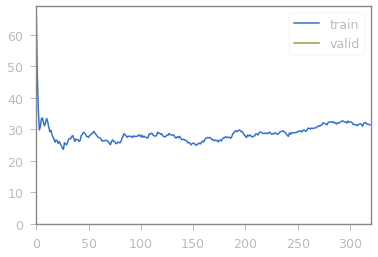

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 79 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6339


epoch,train_loss,valid_loss,accuracy,time
0,29.490847,26.258436,0.858721,01:44


Better model found at epoch 0 with accuracy value: 0.8587213754653931.


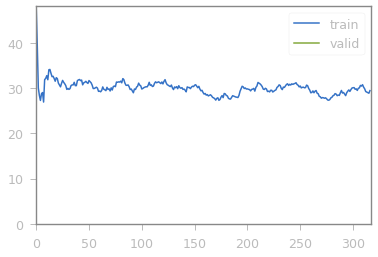

************Round:  3
TTA Accuracy:0.8505850434303284
cycle 0 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6262


epoch,train_loss,valid_loss,accuracy,time
0,29.187298,25.111738,0.866613,01:44


Better model found at epoch 0 with accuracy value: 0.8666134476661682.


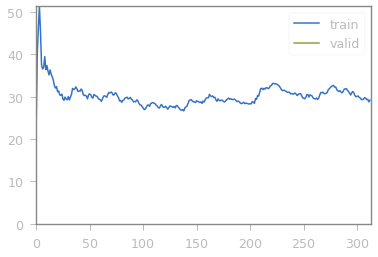

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 67 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6195


epoch,train_loss,valid_loss,accuracy,time
0,29.305344,27.203279,0.853107,01:43


Better model found at epoch 0 with accuracy value: 0.8531073331832886.


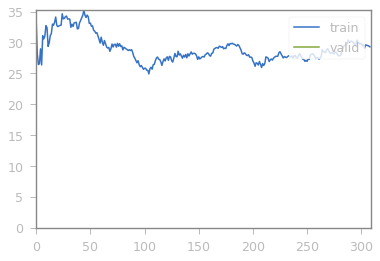

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 59 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6136


epoch,train_loss,valid_loss,accuracy,time
0,26.671207,28.350491,0.845966,01:41


Better model found at epoch 0 with accuracy value: 0.8459657430648804.


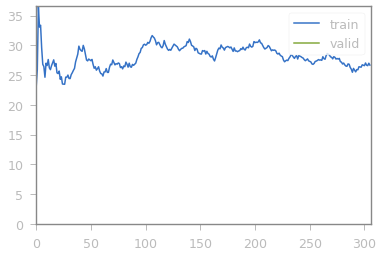

************Round:  6
TTA Accuracy:0.8508850932121277
cycle 0 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 73 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6063


epoch,train_loss,valid_loss,accuracy,time
0,26.019535,28.490627,0.848185,01:42


Better model found at epoch 0 with accuracy value: 0.8481848239898682.


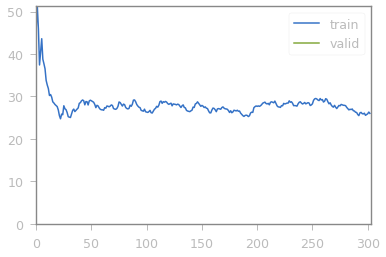

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 69 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5994


epoch,train_loss,valid_loss,accuracy,time
0,29.555943,25.624178,0.861436,01:41


Better model found at epoch 0 with accuracy value: 0.8614357113838196.


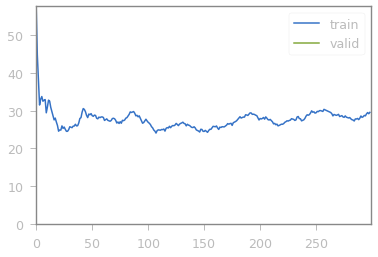

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 67 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5927


epoch,train_loss,valid_loss,accuracy,time
0,24.979990,25.851854,0.860759,01:39


Better model found at epoch 0 with accuracy value: 0.8607594966888428.


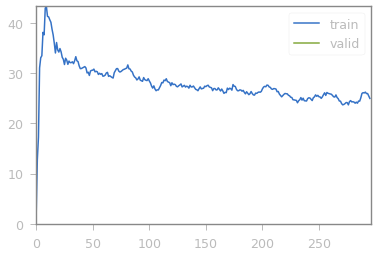

************Round:  9
TTA Accuracy:0.8559855818748474
cycle 0 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 58 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5869


epoch,train_loss,valid_loss,accuracy,time
0,25.938362,26.964237,0.857630,01:36


Better model found at epoch 0 with accuracy value: 0.8576300144195557.


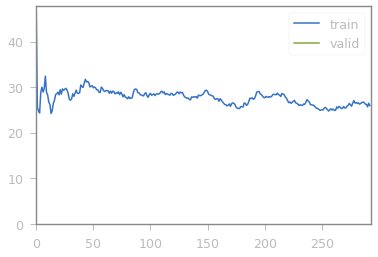

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 71 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5798


epoch,train_loss,valid_loss,accuracy,time
0,28.474285,22.889780,0.877481,01:35


Better model found at epoch 0 with accuracy value: 0.8774805665016174.


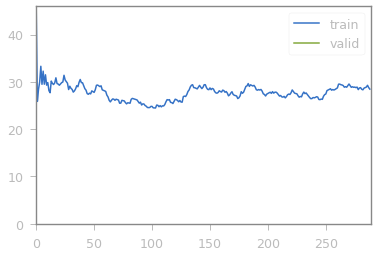

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 59 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5739


epoch,train_loss,valid_loss,accuracy,time
0,28.353477,24.738234,0.867480,01:35


Better model found at epoch 0 with accuracy value: 0.8674803972244263.


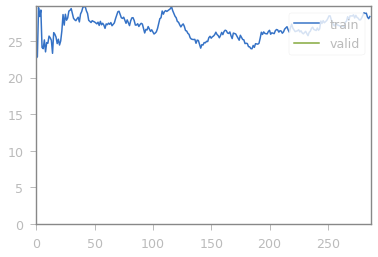

************Round:  12
TTA Accuracy:0.852685272693634
cycle 0 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 64 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5675


epoch,train_loss,valid_loss,accuracy,time
0,25.598625,25.138367,0.864317,01:36


Better model found at epoch 0 with accuracy value: 0.8643171787261963.


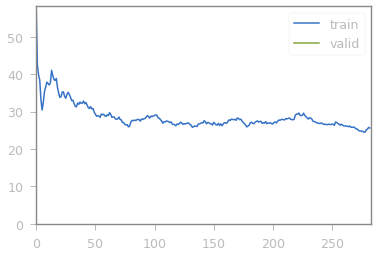

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 60 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5615


epoch,train_loss,valid_loss,accuracy,time
0,29.089613,19.339577,0.896705,01:33


Better model found at epoch 0 with accuracy value: 0.8967052698135376.


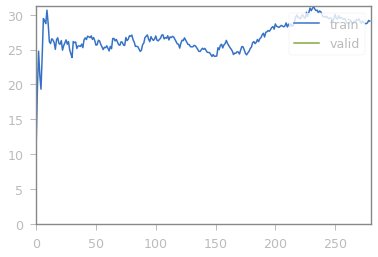

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 90 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6577


epoch,train_loss,valid_loss,accuracy,time
0,25.762720,24.138826,0.869962,01:49


Better model found at epoch 0 with accuracy value: 0.8699619770050049.


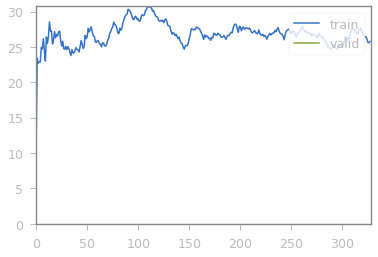

************Round:  0
TTA Accuracy:0.8589859008789062
cycle 1 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 87 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6490


epoch,train_loss,valid_loss,accuracy,time
0,29.233662,21.161901,0.883667,01:48


Better model found at epoch 0 with accuracy value: 0.8836671710014343.


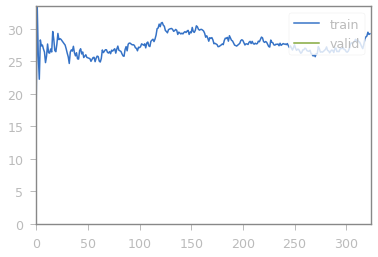

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 84 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6406


epoch,train_loss,valid_loss,accuracy,time
0,26.218454,24.691113,0.867291,01:45


Better model found at epoch 0 with accuracy value: 0.8672911524772644.


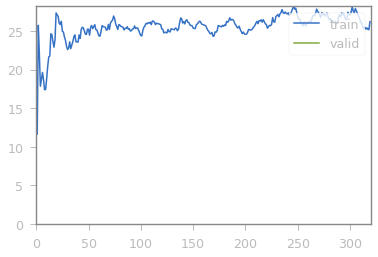

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 80 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6326


epoch,train_loss,valid_loss,accuracy,time
0,25.477226,25.974985,0.859289,01:45


Better model found at epoch 0 with accuracy value: 0.8592885136604309.


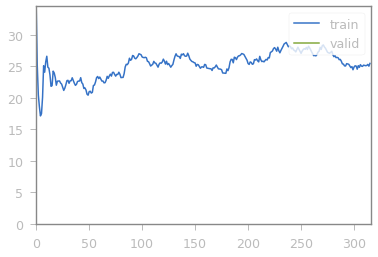

************Round:  3
TTA Accuracy:0.8580858111381531
cycle 1 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 72 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6254


epoch,train_loss,valid_loss,accuracy,time
0,26.887808,24.609295,0.867200,01:43


Better model found at epoch 0 with accuracy value: 0.8672000169754028.


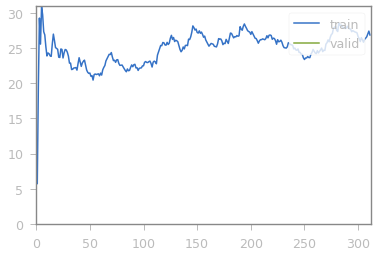

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 64 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6190


epoch,train_loss,valid_loss,accuracy,time
0,25.363285,25.521973,0.861874,01:42


Better model found at epoch 0 with accuracy value: 0.861873984336853.


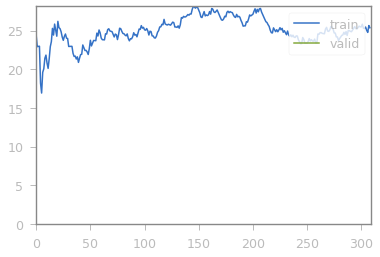

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 70 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6120


epoch,train_loss,valid_loss,accuracy,time
0,25.409451,23.539610,0.872549,01:43


Better model found at epoch 0 with accuracy value: 0.8725489974021912.


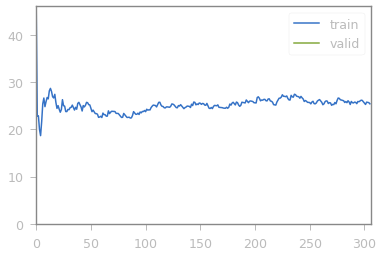

************Round:  6
TTA Accuracy:0.8610861301422119
cycle 1 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 63 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6057


epoch,train_loss,valid_loss,accuracy,time
0,25.658026,23.252861,0.873658,01:39


Better model found at epoch 0 with accuracy value: 0.8736581206321716.


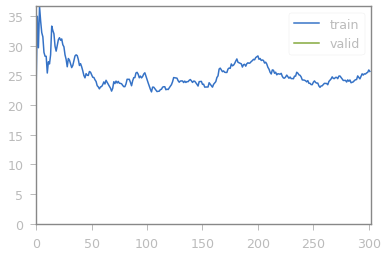

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 67 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5990


epoch,train_loss,valid_loss,accuracy,time
0,25.322784,21.928450,0.880634,01:39


Better model found at epoch 0 with accuracy value: 0.8806343674659729.


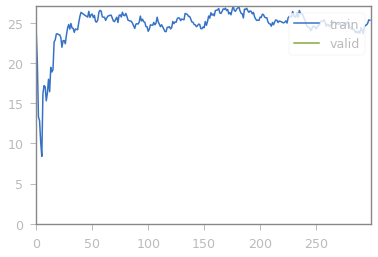

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 54 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5936


epoch,train_loss,valid_loss,accuracy,time
0,27.106569,24.916164,0.865206,01:37


Better model found at epoch 0 with accuracy value: 0.8652064204216003.


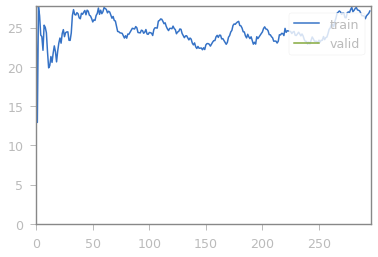

************Round:  9
TTA Accuracy:0.8595859408378601
cycle 1 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 60 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5876


epoch,train_loss,valid_loss,accuracy,time
0,24.419094,24.159527,0.868936,01:37


Better model found at epoch 0 with accuracy value: 0.8689361810684204.


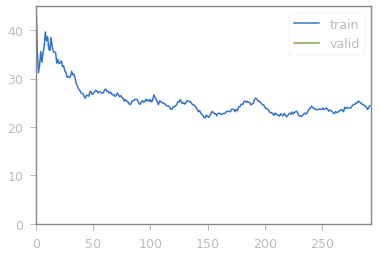

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 63 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5813


epoch,train_loss,valid_loss,accuracy,time
0,26.383383,19.038904,0.897590,01:38


Better model found at epoch 0 with accuracy value: 0.8975903391838074.


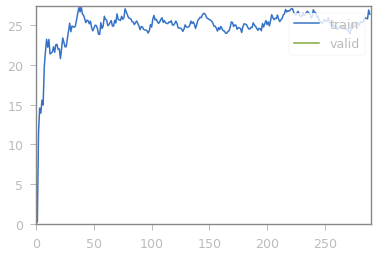

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 61 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5752


epoch,train_loss,valid_loss,accuracy,time
0,22.884178,22.953251,0.874783,01:35


Better model found at epoch 0 with accuracy value: 0.8747826218605042.


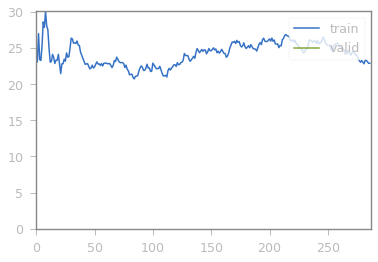

************Round:  12
TTA Accuracy:0.8598859906196594
cycle 1 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399), 27: (13.724313784310782, 14.011400938034058)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 44
Min probability = 0.6
Dropped 65 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5687


epoch,train_loss,valid_loss,accuracy,time
0,23.605917,21.891130,0.881266,01:34


Better model found at epoch 0 with accuracy value: 0.8812664747238159.


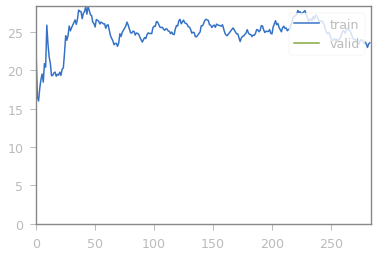

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 43
Min probability = 0.5863636363636363
Dropped 66 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5621


epoch,train_loss,valid_loss,accuracy,time
0,27.214197,22.857243,0.876335,01:33


Better model found at epoch 0 with accuracy value: 0.876334547996521.


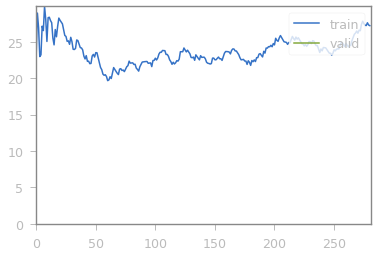

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 89 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6578


epoch,train_loss,valid_loss,accuracy,time
0,25.499981,24.761469,0.866920,01:48


Better model found at epoch 0 with accuracy value: 0.8669201731681824.


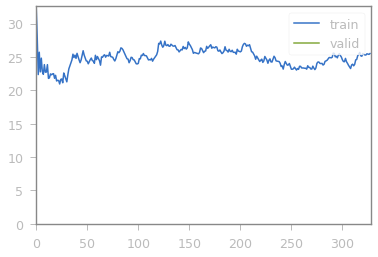

************Round:  0
TTA Accuracy:0.8568856716156006
cycle 2 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399), 27: (13.724313784310782, 14.011400938034058), 30: (1.3349332533373337, 14.311432838439941)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 81 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6497


epoch,train_loss,valid_loss,accuracy,time
0,23.820248,22.017321,0.880677,01:47


Better model found at epoch 0 with accuracy value: 0.8806774616241455.


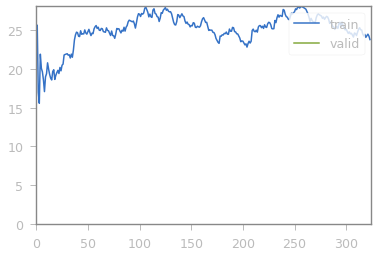

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 75 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6422


epoch,train_loss,valid_loss,accuracy,time
0,24.781187,24.439457,0.869159,01:46


Better model found at epoch 0 with accuracy value: 0.8691588640213013.


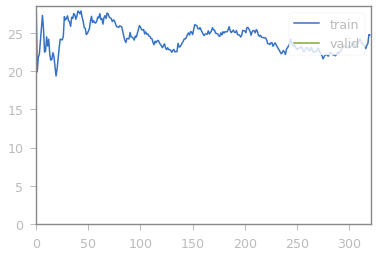

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 74 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6348


epoch,train_loss,valid_loss,accuracy,time
0,25.100611,23.125896,0.875493,01:44


Better model found at epoch 0 with accuracy value: 0.875492513179779.


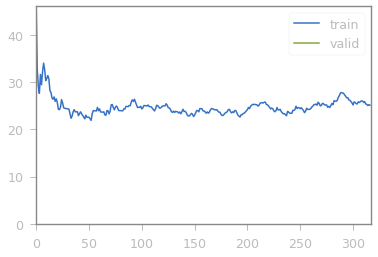

************Round:  3
TTA Accuracy:0.856585681438446
cycle 2 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399), 27: (13.724313784310782, 14.011400938034058), 30: (1.3349332533373337, 14.311432838439941), 33: (4.784760761961904, 14.341431856155396)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6271


epoch,train_loss,valid_loss,accuracy,time
0,22.850298,25.246815,0.863636,01:43


Better model found at epoch 0 with accuracy value: 0.8636363744735718.


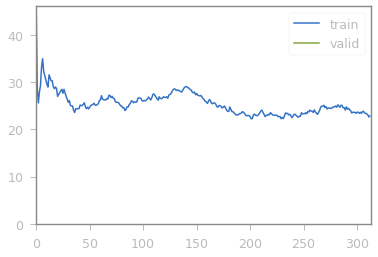

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 61 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6210


epoch,train_loss,valid_loss,accuracy,time
0,24.612930,23.100479,0.875201,01:42


Better model found at epoch 0 with accuracy value: 0.8752012848854065.


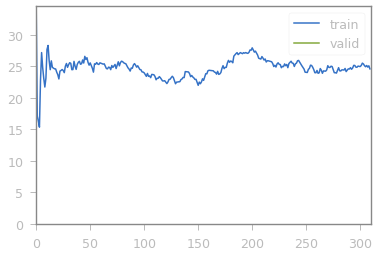

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 67 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6143


epoch,train_loss,valid_loss,accuracy,time
0,23.641483,21.342213,0.884365,01:41


Better model found at epoch 0 with accuracy value: 0.8843648433685303.


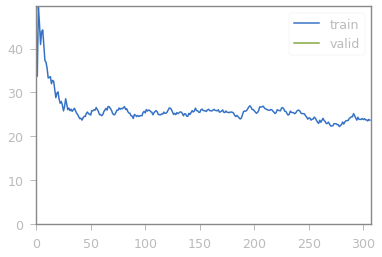

************Round:  6
TTA Accuracy:0.8577857613563538
cycle 2 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399), 27: (13.724313784310782, 14.011400938034058), 30: (1.3349332533373337, 14.311432838439941), 33: (4.784760761961904, 14.341431856155396), 36: (7.859607019649017, 14.221423864364624)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 68 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6075


epoch,train_loss,valid_loss,accuracy,time
0,25.948971,21.794506,0.881481,01:40


Better model found at epoch 0 with accuracy value: 0.8814814686775208.


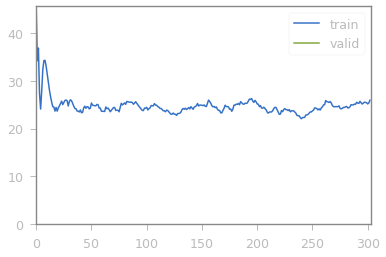

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 59 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6016


epoch,train_loss,valid_loss,accuracy,time
0,25.497372,21.817661,0.883624,01:39


Better model found at epoch 0 with accuracy value: 0.883624255657196.


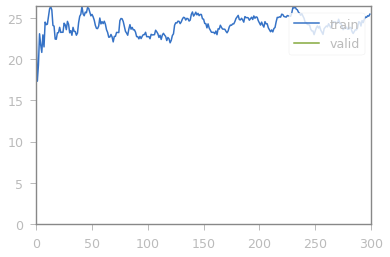

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 55 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5961


epoch,train_loss,valid_loss,accuracy,time
0,25.902960,21.259981,0.884228,01:39


Better model found at epoch 0 with accuracy value: 0.8842281699180603.


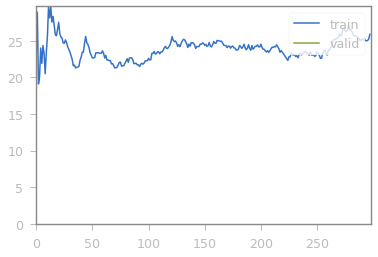

************Round:  9
TTA Accuracy:0.8631862998008728
cycle 2 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399), 27: (13.724313784310782, 14.011400938034058), 30: (1.3349332533373337, 14.311432838439941), 33: (4.784760761961904, 14.341431856155396), 36: (7.859607019649017, 14.221423864364624), 39: (10.589470526473676, 13.68137001991272)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 61 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5900


epoch,train_loss,valid_loss,accuracy,time
0,25.470224,20.442179,0.888983,01:38


Better model found at epoch 0 with accuracy value: 0.8889830708503723.


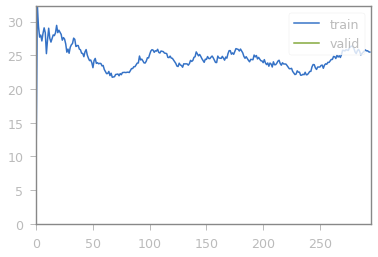

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 66 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5834


epoch,train_loss,valid_loss,accuracy,time
0,25.368500,20.418758,0.889365,01:37


Better model found at epoch 0 with accuracy value: 0.8893653750419617.


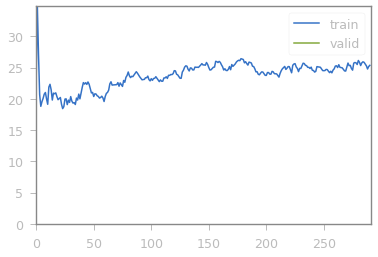

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 61 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5773


epoch,train_loss,valid_loss,accuracy,time
0,21.271526,22.626814,0.878683,01:36


Better model found at epoch 0 with accuracy value: 0.8786828517913818.


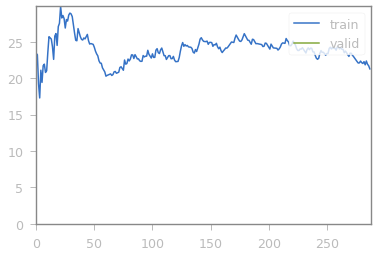

************Round:  12
TTA Accuracy:0.8676867485046387
cycle 2 Error Rate is [{0: (1.3799310034498302, 15.571558475494385), 3: (4.919754012299382, 14.941495656967163), 6: (7.964601769911505, 14.911490678787231), 9: (11.099445027748612, 14.401441812515259), 12: (13.919304034798262, 14.731472730636597), 15: (1.3499325033748288, 14.101409912109375), 18: (5.114744262786863, 14.191418886184692), 21: (8.204589770511472, 13.891386985778809), 24: (10.964451777411133, 14.04140591621399), 27: (13.724313784310782, 14.011400938034058), 30: (1.3349332533373337, 14.311432838439941), 33: (4.784760761961904, 14.341431856155396), 36: (7.859607019649017, 14.221423864364624), 39: (10.589470526473676, 13.68137001991272), 42: (13.409329533523328, 13.231325149536133)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 47
Min probability = 0.640909090909091
Dropped 70 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5703


epoch,train_loss,valid_loss,accuracy,time
0,23.736908,21.680761,0.882456,01:34


Better model found at epoch 0 with accuracy value: 0.8824561238288879.


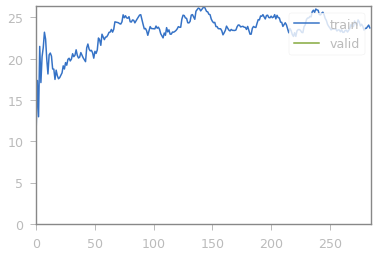

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 47
Min probability = 0.640909090909091
Dropped 63 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5640


epoch,train_loss,valid_loss,accuracy,time
0,23.643103,19.944973,0.891844,01:33


Better model found at epoch 0 with accuracy value: 0.8918439745903015.


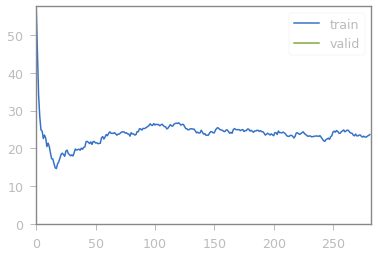

In [36]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedRCELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        k_samples = 100
        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

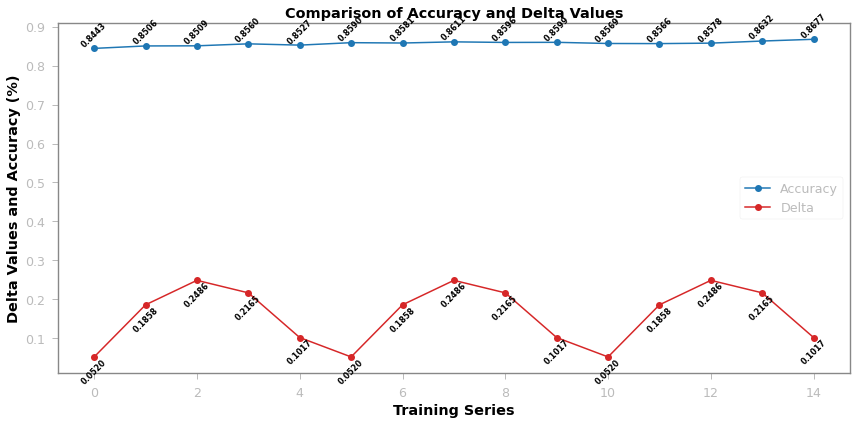

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 87 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,21.245302,21.431219,0.885258,01:48


Better model found at epoch 0 with accuracy value: 0.8852583765983582.


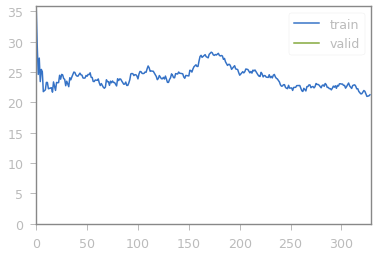

************Round:  0
TTA Accuracy:0.8649864792823792
cycle 0 Error Rate is [{0: (1.3049347532623323, 13.501352071762085)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 81 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,24.489380,22.715719,0.877598,01:47


Better model found at epoch 0 with accuracy value: 0.8775981664657593.


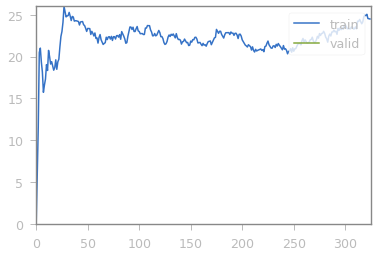

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 71 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6428


epoch,train_loss,valid_loss,accuracy,time
0,23.970604,22.208141,0.880934,01:46


Better model found at epoch 0 with accuracy value: 0.8809338808059692.


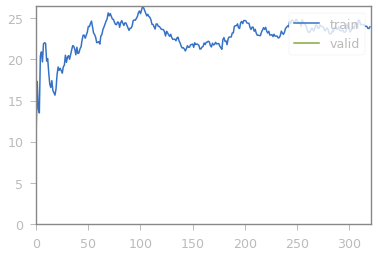

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 69 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6359


epoch,train_loss,valid_loss,accuracy,time
0,23.388670,20.601994,0.888277,01:45


Better model found at epoch 0 with accuracy value: 0.8882769346237183.


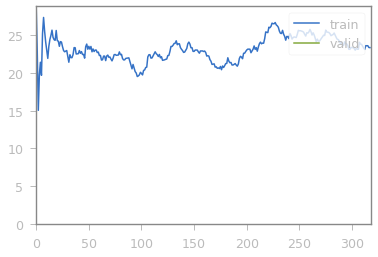

************Round:  3
TTA Accuracy:0.8673867583274841
cycle 0 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 70 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6289


epoch,train_loss,valid_loss,accuracy,time
0,21.974117,19.674122,0.893397,01:43


Better model found at epoch 0 with accuracy value: 0.8933969736099243.


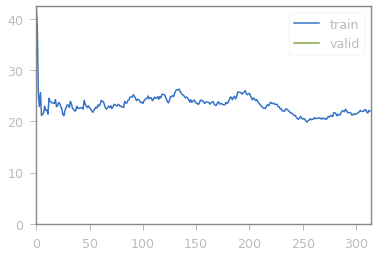

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 65 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6224


epoch,train_loss,valid_loss,accuracy,time
0,21.033676,19.204147,0.896302,01:43


Better model found at epoch 0 with accuracy value: 0.8963022232055664.


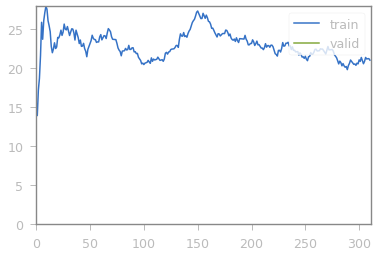

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 68 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6156


epoch,train_loss,valid_loss,accuracy,time
0,23.552067,21.540783,0.882210,01:42


Better model found at epoch 0 with accuracy value: 0.8822095990180969.


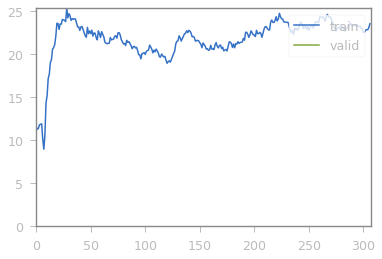

************Round:  6
TTA Accuracy:0.8646864891052246
cycle 0 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 75 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6081


epoch,train_loss,valid_loss,accuracy,time
0,23.319113,20.274899,0.889803,01:41


Better model found at epoch 0 with accuracy value: 0.8898026347160339.


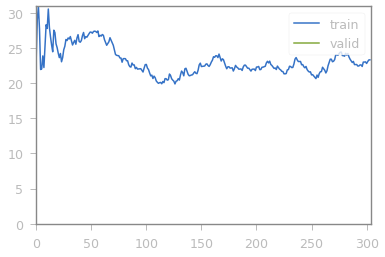

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 69 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6012


epoch,train_loss,valid_loss,accuracy,time
0,24.745518,19.595900,0.893511,01:40


Better model found at epoch 0 with accuracy value: 0.8935108184814453.


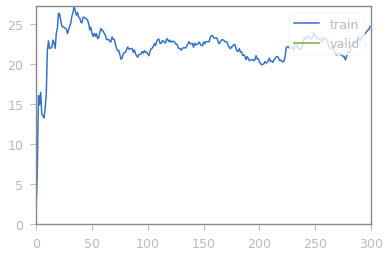

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 66 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5946


epoch,train_loss,valid_loss,accuracy,time
0,21.507732,19.715826,0.893188,01:38


Better model found at epoch 0 with accuracy value: 0.8931875228881836.


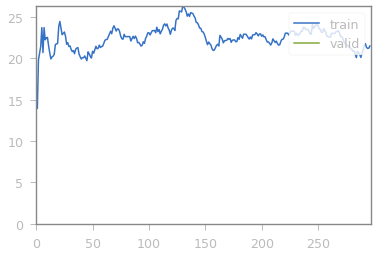

************Round:  9
TTA Accuracy:0.8682868480682373
cycle 0 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 64 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5882


epoch,train_loss,valid_loss,accuracy,time
0,22.437365,21.006851,0.886054,01:37


Better model found at epoch 0 with accuracy value: 0.8860543966293335.


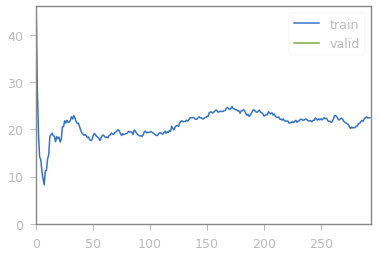

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 57 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5825


epoch,train_loss,valid_loss,accuracy,time
0,22.183653,19.049887,0.897854,01:36


Better model found at epoch 0 with accuracy value: 0.8978540897369385.


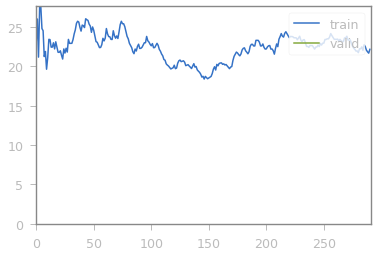

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 63 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5762


epoch,train_loss,valid_loss,accuracy,time
0,22.972727,21.529749,0.883681,01:35


Better model found at epoch 0 with accuracy value: 0.8836805820465088.


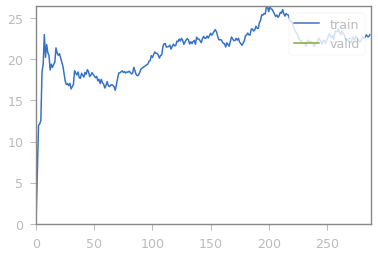

************Round:  12
TTA Accuracy:0.8652865290641785
cycle 0 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 61 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5701


epoch,train_loss,valid_loss,accuracy,time
0,21.337639,20.507858,0.888596,01:34


Better model found at epoch 0 with accuracy value: 0.8885964751243591.


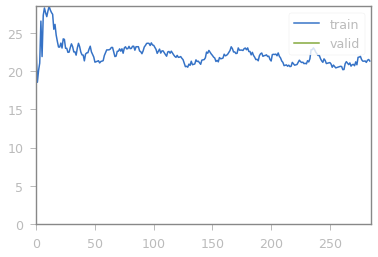

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 58 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5643


epoch,train_loss,valid_loss,accuracy,time
0,22.910877,21.384043,0.883865,01:33


Better model found at epoch 0 with accuracy value: 0.883865237236023.


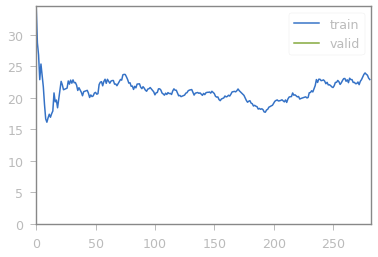

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,20.364662,22.237164,0.879087,01:48


Better model found at epoch 0 with accuracy value: 0.8790874481201172.


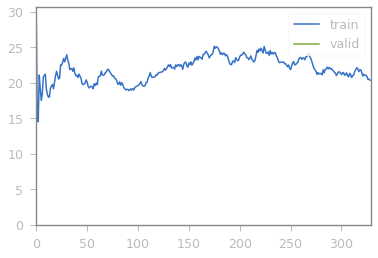

************Round:  0
TTA Accuracy:0.8658865690231323
cycle 1 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 79 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6500


epoch,train_loss,valid_loss,accuracy,time
0,22.821253,22.408773,0.878462,01:47


Better model found at epoch 0 with accuracy value: 0.8784615397453308.


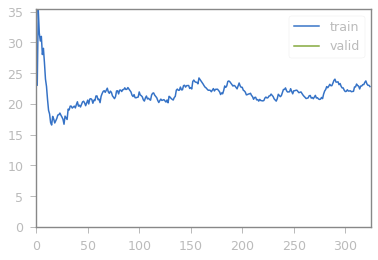

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 86 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6414


epoch,train_loss,valid_loss,accuracy,time
0,22.073786,22.322662,0.878315,01:45


Better model found at epoch 0 with accuracy value: 0.8783151507377625.


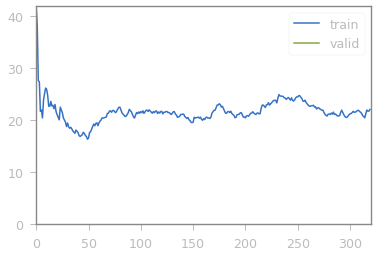

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 71 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6343


epoch,train_loss,valid_loss,accuracy,time
0,20.949833,20.119995,0.890379,01:44


Better model found at epoch 0 with accuracy value: 0.8903785347938538.


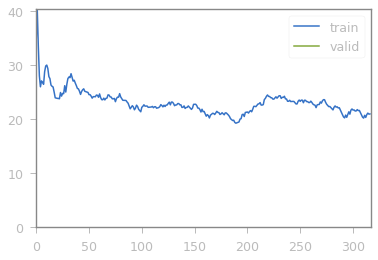

************Round:  3
TTA Accuracy:0.8649864792823792
cycle 1 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 69 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6274


epoch,train_loss,valid_loss,accuracy,time
0,22.608618,22.441458,0.877990,01:43


Better model found at epoch 0 with accuracy value: 0.8779904246330261.


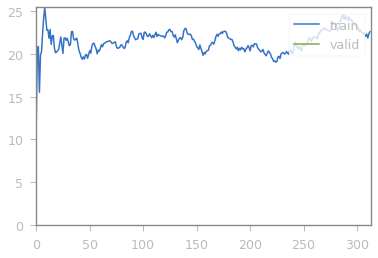

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 67 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6207


epoch,train_loss,valid_loss,accuracy,time
0,20.510092,23.463882,0.872683,01:42


Better model found at epoch 0 with accuracy value: 0.8726833462715149.


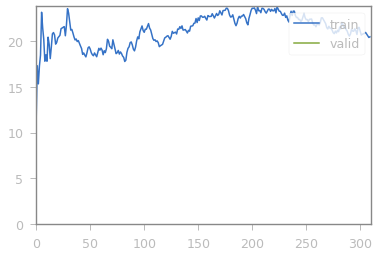

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 64 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6143


epoch,train_loss,valid_loss,accuracy,time
0,20.186171,21.171827,0.885179,01:41


Better model found at epoch 0 with accuracy value: 0.8851791620254517.


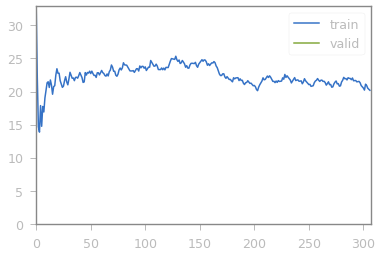

************Round:  6
TTA Accuracy:0.864086389541626
cycle 1 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 72 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6071


epoch,train_loss,valid_loss,accuracy,time
0,21.793001,19.695845,0.893740,01:40


Better model found at epoch 0 with accuracy value: 0.8937397003173828.


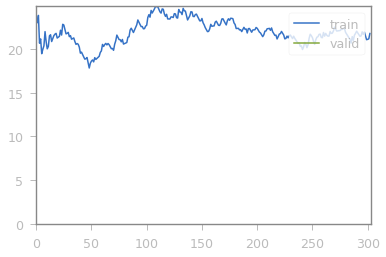

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 73 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5998


epoch,train_loss,valid_loss,accuracy,time
0,22.260534,21.847435,0.881568,01:38


Better model found at epoch 0 with accuracy value: 0.8815679550170898.


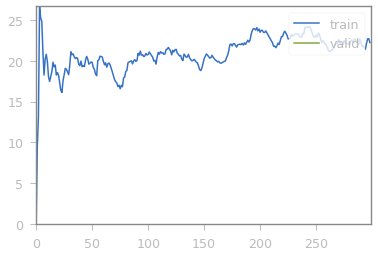

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 62 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5936


epoch,train_loss,valid_loss,accuracy,time
0,21.328112,21.556719,0.883741,01:38


Better model found at epoch 0 with accuracy value: 0.8837405443191528.


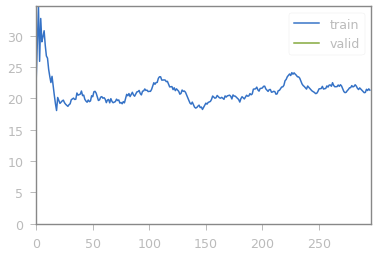

************Round:  9
TTA Accuracy:0.8706870675086975
cycle 1 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 65 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5871


epoch,train_loss,valid_loss,accuracy,time
0,18.752007,20.002975,0.891823,01:37


Better model found at epoch 0 with accuracy value: 0.8918228149414062.


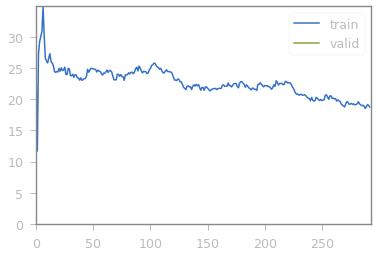

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 69 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5802


epoch,train_loss,valid_loss,accuracy,time
0,25.505243,19.458229,0.894828,01:36


Better model found at epoch 0 with accuracy value: 0.8948276042938232.


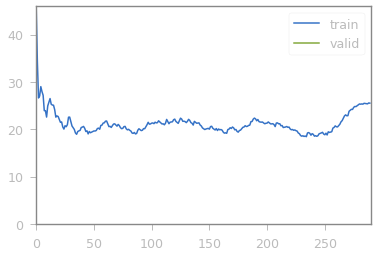

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 59 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5743


epoch,train_loss,valid_loss,accuracy,time
0,20.533844,21.585825,0.882404,01:35


Better model found at epoch 0 with accuracy value: 0.8824042081832886.


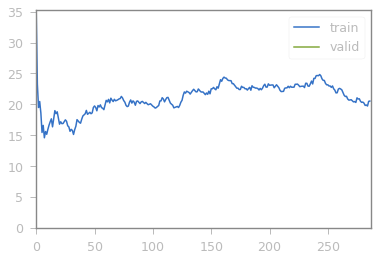

************Round:  12
TTA Accuracy:0.8703870177268982
cycle 1 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249), 27: (13.859307034648271, 12.96129822731018)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 57 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5686


epoch,train_loss,valid_loss,accuracy,time
0,21.498199,19.975880,0.891821,01:34


Better model found at epoch 0 with accuracy value: 0.8918206095695496.


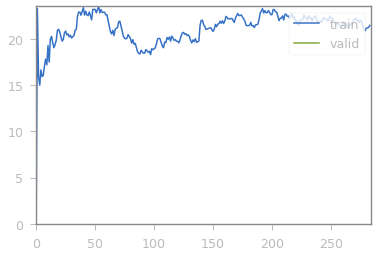

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 59 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5627


epoch,train_loss,valid_loss,accuracy,time
0,21.787029,20.671509,0.887111,01:33


Better model found at epoch 0 with accuracy value: 0.8871111273765564.


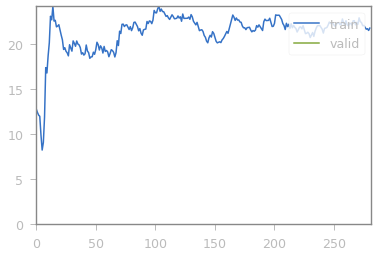

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 89 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6578


epoch,train_loss,valid_loss,accuracy,time
0,22.343529,21.890181,0.882129,01:48


Better model found at epoch 0 with accuracy value: 0.8821292519569397.


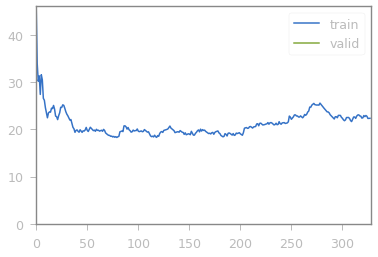

************Round:  0
TTA Accuracy:0.8685868382453918
cycle 2 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249), 27: (13.859307034648271, 12.96129822731018), 30: (1.3349332533373337, 13.141316175460815)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 82 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6496


epoch,train_loss,valid_loss,accuracy,time
0,21.918184,20.197426,0.890685,01:47


Better model found at epoch 0 with accuracy value: 0.8906851410865784.


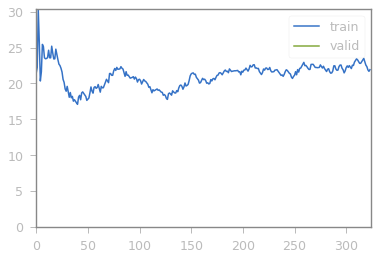

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 77 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6419


epoch,train_loss,valid_loss,accuracy,time
0,22.945410,18.520069,0.900234,01:46


Better model found at epoch 0 with accuracy value: 0.900233805179596.


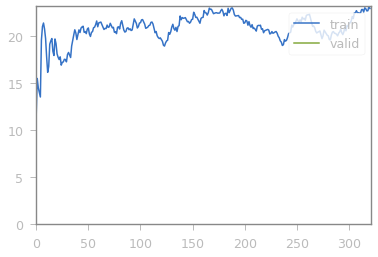

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 72 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6347


epoch,train_loss,valid_loss,accuracy,time
0,20.153421,21.308781,0.884161,01:44


Better model found at epoch 0 with accuracy value: 0.8841607570648193.


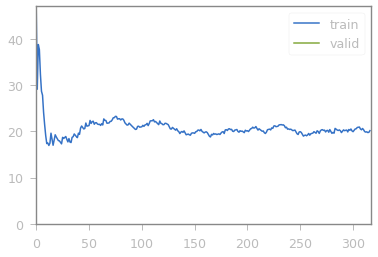

************Round:  3
TTA Accuracy:0.8682868480682373
cycle 2 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249), 27: (13.859307034648271, 12.96129822731018), 30: (1.3349332533373337, 13.141316175460815), 33: (4.799760011999399, 13.17131519317627)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 72 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6275


epoch,train_loss,valid_loss,accuracy,time
0,20.942541,19.342312,0.894821,01:43


Better model found at epoch 0 with accuracy value: 0.8948206901550293.


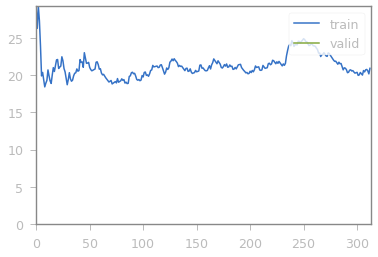

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 69 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6206


epoch,train_loss,valid_loss,accuracy,time
0,21.060913,19.866459,0.892828,01:42


Better model found at epoch 0 with accuracy value: 0.8928283452987671.


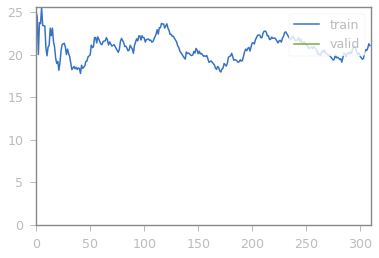

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 74 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6132


epoch,train_loss,valid_loss,accuracy,time
0,19.503433,20.647083,0.887439,01:41


Better model found at epoch 0 with accuracy value: 0.8874388337135315.


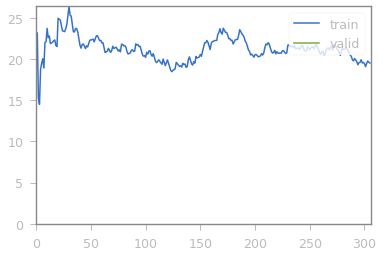

************Round:  6
TTA Accuracy:0.8622862100601196
cycle 2 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249), 27: (13.859307034648271, 12.96129822731018), 30: (1.3349332533373337, 13.141316175460815), 33: (4.799760011999399, 13.17131519317627), 36: (8.024598770061498, 13.771378993988037)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 67 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6065


epoch,train_loss,valid_loss,accuracy,time
0,22.070036,21.002245,0.886232,01:40


Better model found at epoch 0 with accuracy value: 0.8862324953079224.


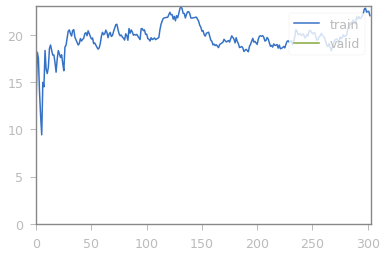

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 69 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5996


epoch,train_loss,valid_loss,accuracy,time
0,21.376232,19.064207,0.896580,01:38


Better model found at epoch 0 with accuracy value: 0.8965804576873779.


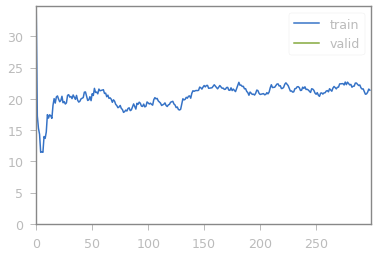

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 73 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5923


epoch,train_loss,valid_loss,accuracy,time
0,19.476458,18.410379,0.902027,01:38


Better model found at epoch 0 with accuracy value: 0.9020270109176636.


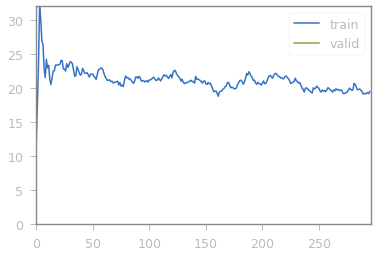

************Round:  9
TTA Accuracy:0.8676867485046387
cycle 2 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249), 27: (13.859307034648271, 12.96129822731018), 30: (1.3349332533373337, 13.141316175460815), 33: (4.799760011999399, 13.17131519317627), 36: (8.024598770061498, 13.771378993988037), 39: (11.159442027898603, 13.231325149536133)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 76 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5847


epoch,train_loss,valid_loss,accuracy,time
0,21.435074,19.402729,0.895637,01:37


Better model found at epoch 0 with accuracy value: 0.8956372737884521.


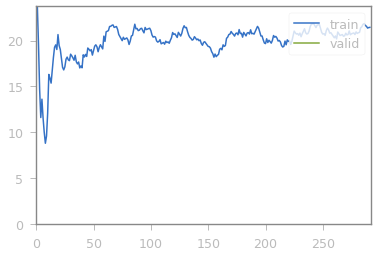

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 47
Min probability = 0.640909090909091
Dropped 63 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5784


epoch,train_loss,valid_loss,accuracy,time
0,17.903828,20.582092,0.888408,01:35


Better model found at epoch 0 with accuracy value: 0.8884083032608032.


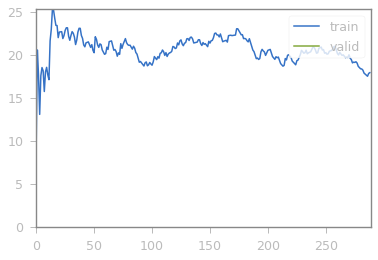

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 47
Min probability = 0.640909090909091
Dropped 66 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5718


epoch,train_loss,valid_loss,accuracy,time
0,20.935316,17.647732,0.904637,01:35


Better model found at epoch 0 with accuracy value: 0.9046369194984436.


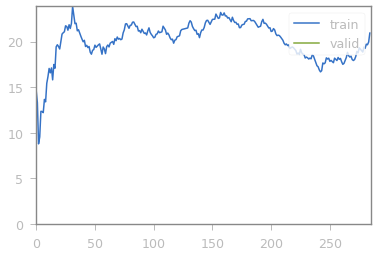

************Round:  12
TTA Accuracy:0.866486668586731
cycle 2 Error Rate is [{0: (1.3049347532623323, 13.501352071762085), 3: (4.619769011549424, 13.261324167251587), 6: (7.664616769161547, 13.531351089477539), 9: (10.814459277036148, 13.17131519317627), 12: (13.57432128393581, 13.471347093582153), 15: (1.3199340032998386, 13.411343097686768), 18: (4.859757012149391, 13.501352071762085), 21: (7.859607019649017, 13.591361045837402), 24: (10.964451777411133, 12.931293249130249), 27: (13.859307034648271, 12.96129822731018), 30: (1.3349332533373337, 13.141316175460815), 33: (4.799760011999399, 13.17131519317627), 36: (8.024598770061498, 13.771378993988037), 39: (11.159442027898603, 13.231325149536133), 42: (14.234288285585716, 13.351333141326904)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 46
Min probability = 0.6272727272727273
Dropped 54 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5664


epoch,train_loss,valid_loss,accuracy,time
0,21.107929,16.451036,0.910777,01:34


Better model found at epoch 0 with accuracy value: 0.9107773900032043.


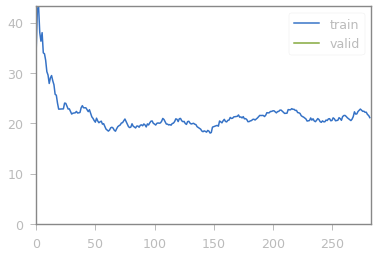

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 45
Min probability = 0.6136363636363636
Dropped 56 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5608


epoch,train_loss,valid_loss,accuracy,time
0,20.353338,17.151402,0.906334,01:33


Better model found at epoch 0 with accuracy value: 0.9063336253166199.


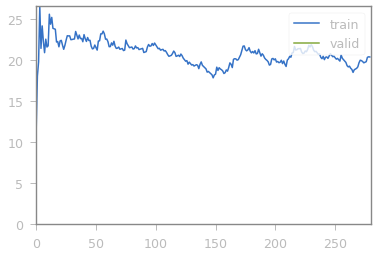

In [41]:
delta_max = 0.50
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedRCELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

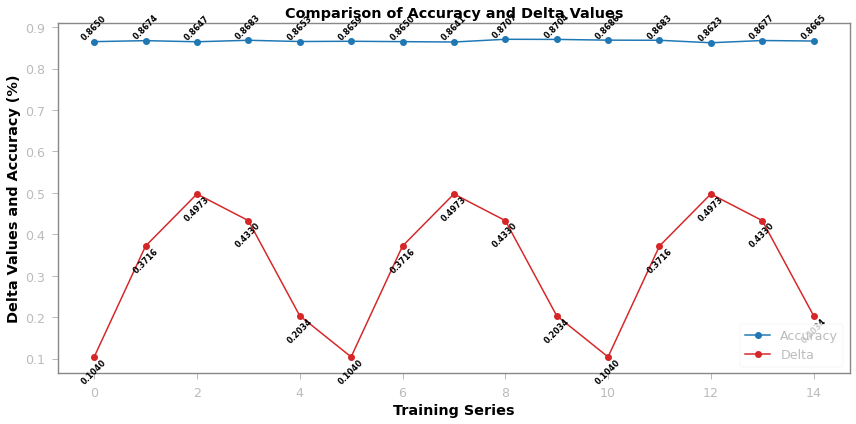

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
